In [1]:
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

## Linear regression

In [3]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

In [4]:
def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

## Regression Model  - Sample vs Population Lines ##

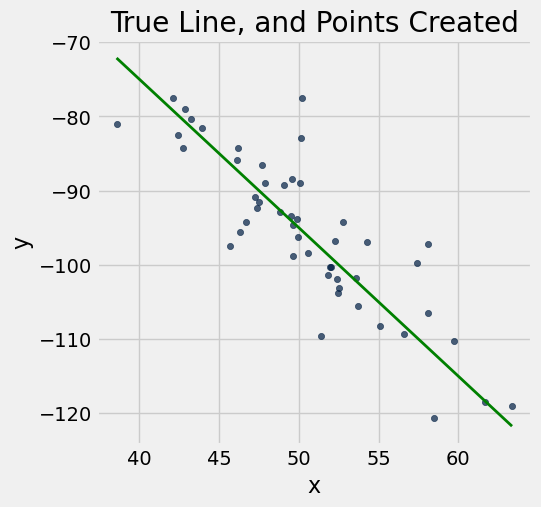

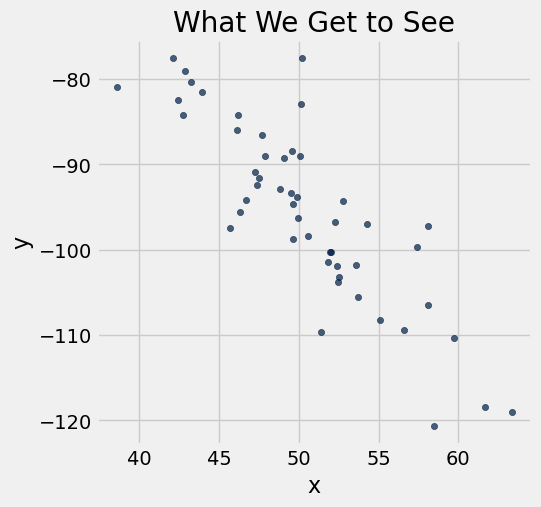

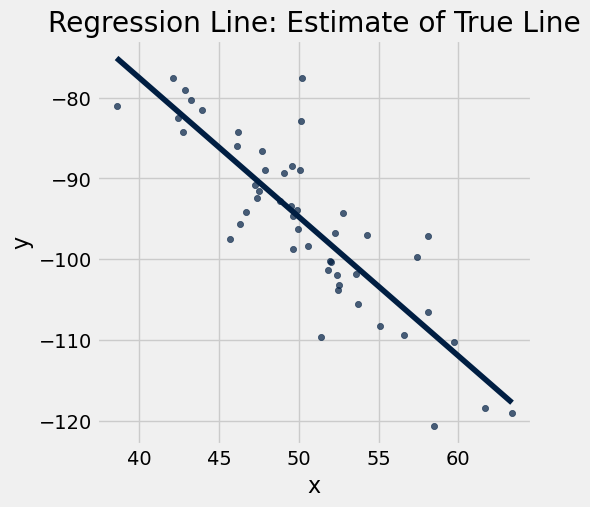

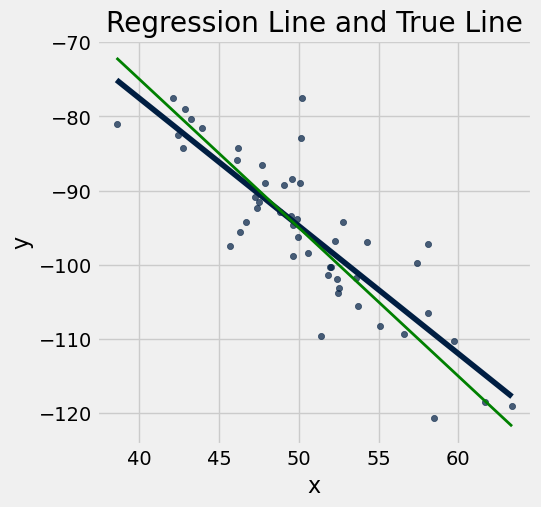

In [5]:
draw_and_compare(-2, 5, 50)

## Prediction ##

In [6]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


In [7]:
births = births.where('Gestational Days', are.between(240, 320))

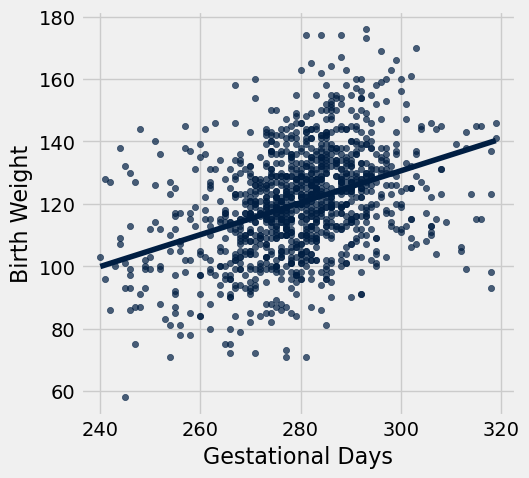

In [8]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [9]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

130.53859795467929

## Confidence Interval for Prediction ##

In [10]:
def bootstrap_prediction(t, x, y, new_x, repetitions=1000):

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')') 

Approximate 95%-confidence interval for height of true line:
128.625644786 132.36756873 (width = 3.74192394405 )


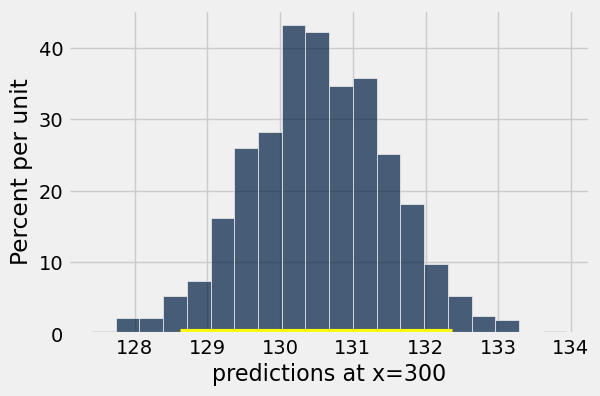

In [11]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

## Inference for the Slope ##

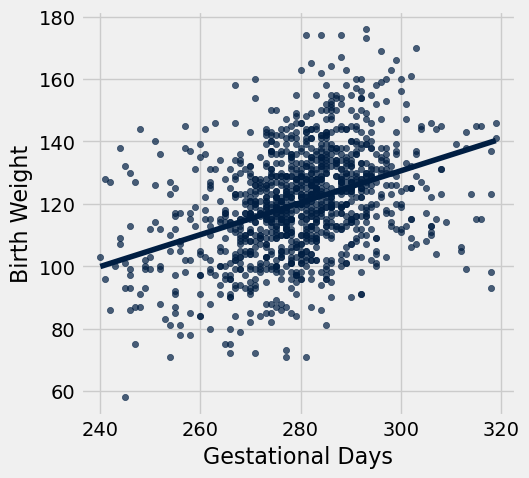

In [12]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [13]:
slope(births, 'Gestational Days', 'Birth Weight')

0.5110166711567975

In [14]:
def bootstrap_slope(t, x, y, repetitions=1000):
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(left, 'to', right)

**Know how to do the function above!**

Slope of regression line: 0.511016671157
Approximate 95%-confidence interval for the slope of the true line:
0.430205716063 to 0.592978476797


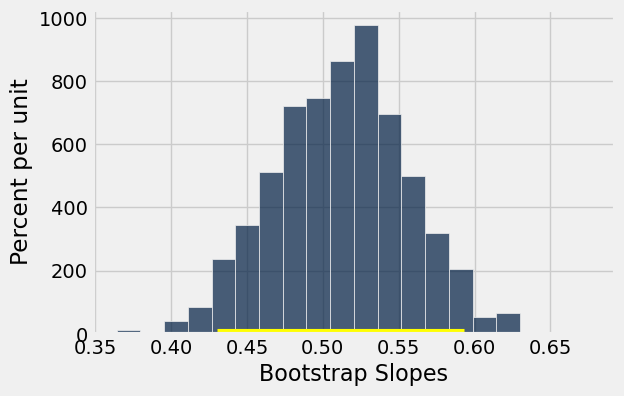

In [15]:
bootstrap_slope(births, 'Gestational Days', 'Birth Weight')

## Rain on the Regression Parade

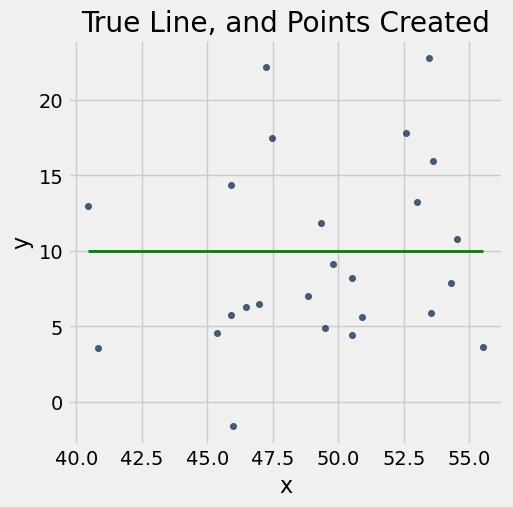

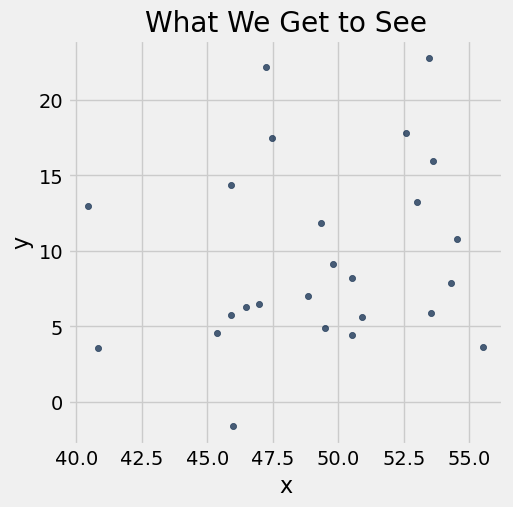

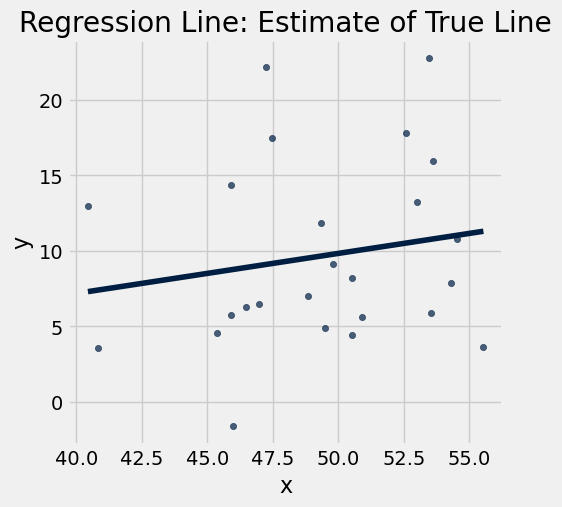

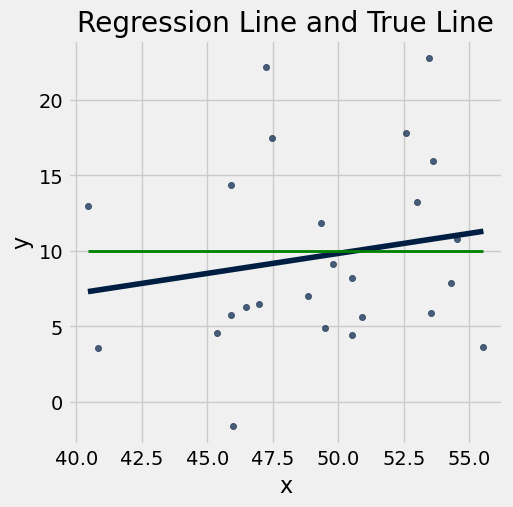

In [16]:
draw_and_compare(0, 10, 25)

**Null Hypothesis.** Slope of true line = 0.

**Alternative Hypothesis.** Slope of true line is not 0.

In [17]:
slope(births, 'Maternal Age', 'Birth Weight')

0.10714722656623907

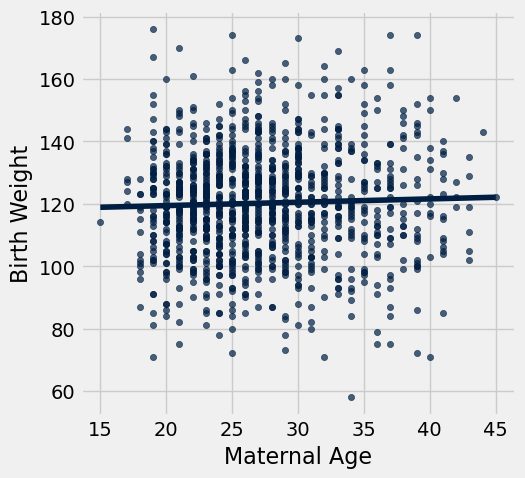

In [18]:
births.scatter('Maternal Age', 'Birth Weight', fit_line=True)

Slope of regression line: 0.107147226566
Approximate 95%-confidence interval for the slope of the true line:
-0.0802568701995 to 0.294001871816


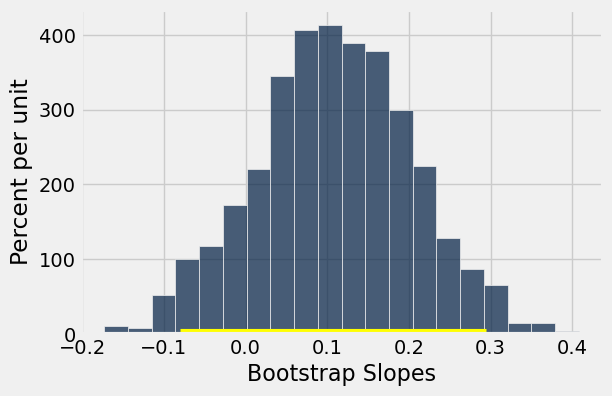

In [19]:
bootstrap_slope(births, 'Maternal Age', 'Birth Weight', 1000)

## Multiple Regression

In [20]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


In [21]:
correlation(births, 'Birth Weight', 'Gestational Days')

0.40754279338885108

In [22]:
correlation(births, 'Birth Weight', 'Maternal Age')

0.026982911002929499

In [23]:
correlation(births, 'Birth Weight', 'Maternal Height')

0.20370417718968034

In [24]:
correlation(births, 'Birth Weight', 'Maternal Pregnancy Weight')

0.15592327018706931

What if we try to predict birth weight from gestational days, maternal height, and maternal pregnancy weight?

In [25]:
def multiple_regression_rmse(gest_days_mult, mat_height_mult, mat_preg_weight_mult, intercept):
    
    gest_days = births.column('Gestational Days')
    mat_height = births.column('Maternal Height')
    mat_preg_weight = births.column('Maternal Pregnancy Weight')
    
    y = births.column('Birth Weight')
    
    prediction = sum([
        gest_days_mult * gest_days,
        mat_height_mult * mat_height,
        mat_preg_weight_mult * mat_preg_weight,
        intercept]
    )
    
    mse = np.mean((y - prediction) ** 2)
    return np.sqrt(mse)

In [26]:
best = minimize(multiple_regression_rmse)
best

array([ 0.3707216 ,  0.09485383,  0.10960043, -4.16139904])

This means that our prediction for birth weight is:

0.3707216(*number of gestational days*) + 0.09485383(*Maternal Height*) + 0.10960043(*Maternal Pregnancy Weight*) + -4.16139904

In [27]:
mult_predictions = sum([
    best.item(0) * births.column('Gestational Days'),
    best.item(1) * births.column('Maternal Height'),
    best.item(2) * births.column('Maternal Pregnancy Weight'),
    best.item(3)]
)

mult_resid = births.column('Birth Weight') - mult_predictions 

In [28]:
births = births.with_columns(
    'Mult Predictions', mult_predictions,
    'Mult Residuals', mult_resid 
)

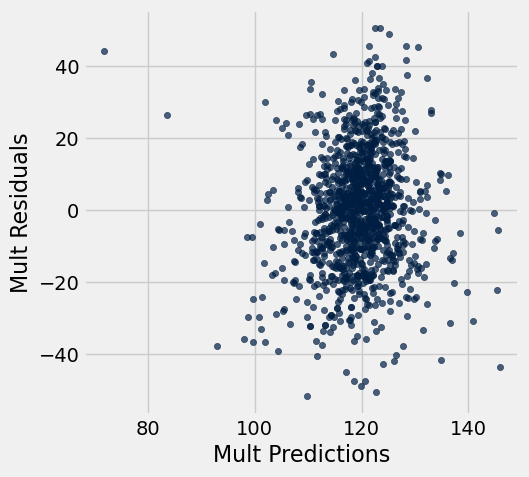

In [29]:
births.scatter('Mult Predictions', 'Mult Residuals')

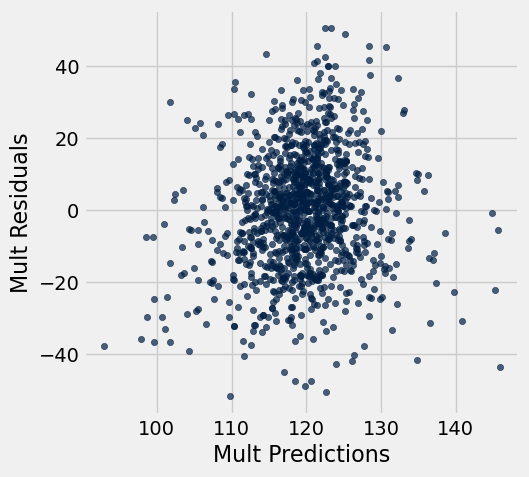

In [30]:
births.where('Mult Predictions', are.between(90, 150)).scatter('Mult Predictions', 'Mult Residuals')

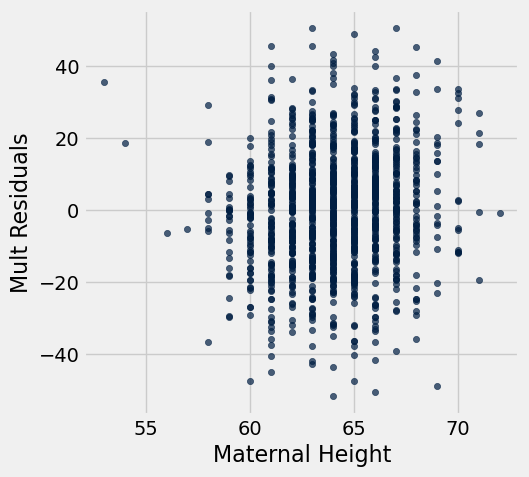

In [31]:
births.scatter('Maternal Height', 'Mult Residuals')

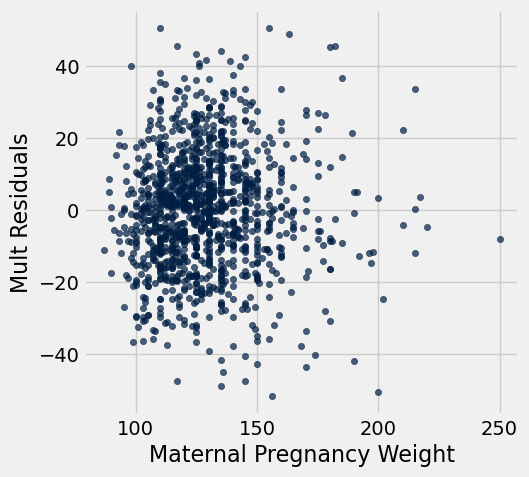

In [32]:
births.scatter('Maternal Pregnancy Weight', 'Mult Residuals')

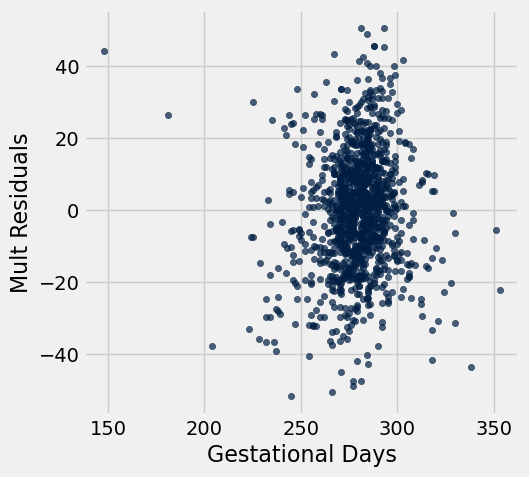

In [33]:
births.scatter('Gestational Days', 'Mult Residuals')

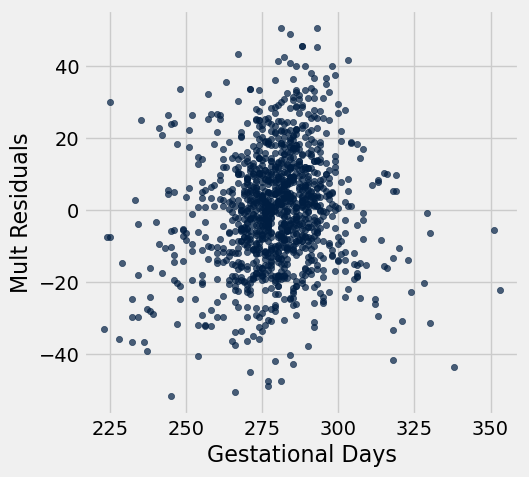

In [34]:
births.where('Gestational Days', are.between(210, 360)).scatter('Gestational Days', 'Mult Residuals')